In [14]:
from torchvision import transforms, models, datasets
import torch

In [9]:
data_dir = './flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [5]:
means = [0.485, 0.456, 0.406]
varis = [0.229, 0.224, 0.225]
data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomGrayscale(p=0.025),
        transforms.ToTensor(),
        transforms.Normalize(means, varis)    
    ]),
    'valid': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(means, varis)
    ])
}

In [16]:
batch_size = 8
import os
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size= batch_size, shuffle=True) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [10]:
import json
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [11]:
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

In [12]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array(varis) + np.array(means)
    image = image.clip(0,1)
    
    return image

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch import nn
import torch.optim as optim
from PIL import Image


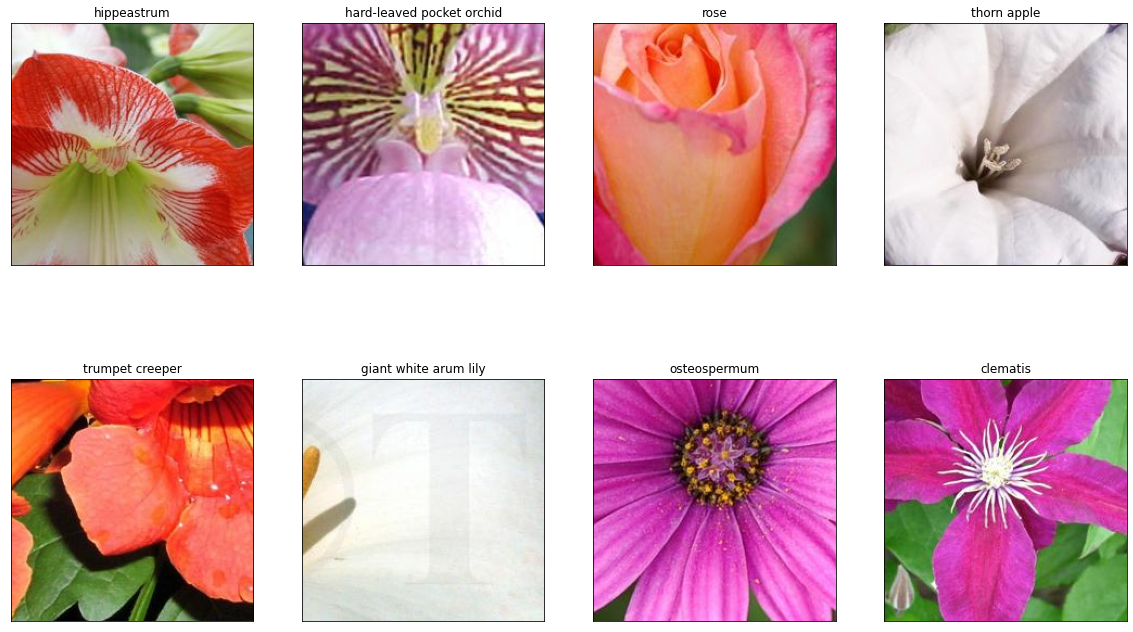

In [18]:
fig = plt.figure(figsize=(20, 12))
cols = 4
rows = 2

dataiter = iter(dataloaders['valid'])
inputs, classes = dataiter.next()
for idx in range (cols * rows):
    ax = fig.add_subplot(rows, cols, idx+1, xticks=[], yticks=[])
    ax.set_title(cat_to_name[str(int(class_names[classes[idx]]))])
    plt.imshow(im_convert(inputs[idx]))

plt.show()

In [19]:
model_name = 'resnet'
feature_extract = True

In [21]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training On CPU...')
else:
    print('CUDA is available! Training on GPU ..')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is available! Training on GPU ..


In [22]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [24]:
model_ft = models.resnet152()
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0;
    
    if model_name == 'resnet':
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
            nn.Linear(num_ftrs, 102),
            nn.LogSoftmax(dim=1)
        )
        
        input_size = 224
        
    return model_ft, input_size

In [28]:
model_ft, input_size = initialize_model('resnet', 102, feature_extract, use_pretrained=True)

model_ft = model_ft.to(device)

filename = 'checkpoint.pth'

params_to_update = model_ft.parameters()

print('parameter to learn:')

if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print('\t', name)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /home/andy/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

parameter to learn:
	 fc.0.weight
	 fc.0.bias


In [29]:
optimizer_ft = optim.Adam(params_to_update, lr = 1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

criterion = nn.NLLLoss()

In [48]:
import copy
import time
def train_model(model, dataloaders, criterion, optimizer, num_epoches = 25, filename=filename):
    since = time.time()
    best_acc = 0
    
    model.to(device)
    
    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['lr']]
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epoches):
        print('Epoch {}/{}'.format(epoch, num_epoches-1))
        print('-'*10)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            runing_loss = 0.0
            runing_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                runing_loss += loss.item() * inputs.size(0)
                runing_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = runing_loss / len(dataloaders[phase].dataset)
            epoch_acc = runing_corrects.double() / len(dataloaders[phase].dataset)
            
            time_elapsed = time.time() - since
            print('Time elapse {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                    'state_dict' : model.state_dict(),
                    'best_acc': best_acc,
                    'optimizer': optimizer.state_dict()
                }
                torch.save(state, filename)
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                scheduler.step(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_acc)
#                 scheduler.step(epoch_loss)
        print("optimizer learning rate: {:.07f}".format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
    
    time_elapsed = time.time() - since
    print('Training complet in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc : {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs
    

In [40]:
model_ft, val_acc_his, train_acc_his, valid_losses, train_losses, LRs = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epoches=20)

Epoch 0/19
----------
Time elapse 1m 22s
train Loss: 6.6008
Time elapse 1m 29s
valid Loss: 4.6800


/home/andy/anaconda3/envs/py39/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


optimizer learning rate: 0.0100000
Epoch 1/19
----------
Time elapse 2m 54s
train Loss: 6.5601
Time elapse 3m 1s
valid Loss: 3.6333
optimizer learning rate: 0.0100000
Epoch 2/19
----------
Time elapse 4m 27s
train Loss: 6.1920
Time elapse 4m 34s
valid Loss: 4.1445
optimizer learning rate: 0.0100000
Epoch 3/19
----------
Time elapse 5m 57s
train Loss: 6.2207
Time elapse 6m 3s
valid Loss: 4.2488
optimizer learning rate: 0.0100000
Epoch 4/19
----------
Time elapse 7m 27s
train Loss: 6.1240
Time elapse 7m 34s
valid Loss: 4.1214
optimizer learning rate: 0.0100000
Epoch 5/19
----------
Time elapse 8m 57s
train Loss: 6.0329
Time elapse 9m 4s
valid Loss: 4.1008
optimizer learning rate: 0.0100000
Epoch 6/19
----------
Time elapse 10m 27s
train Loss: 5.9949
Time elapse 10m 34s
valid Loss: 3.9285
optimizer learning rate: 0.0100000
Epoch 7/19
----------
Time elapse 11m 58s
train Loss: 5.9249
Time elapse 12m 5s
valid Loss: 4.3855
optimizer learning rate: 0.0100000
Epoch 8/19
----------
Time elapse 

NameError: name 'bet_acc' is not defined

In [46]:
checkpoint = torch.load(filename)
model_ft = checkpoint

for param in model_ft.parameters():
    param.requires_grad = True
    
optimizer = optim.Adam(model_ft.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# optimizer.load_state_dict(checkpoint['optimizer'])
criterion = nn.NLLLoss()


In [105]:
model_ft, val_acc_his, train_acc_his, valid_losses, train_losses, LRs = train_model(model_ft, dataloaders, criterion, optimizer, num_epoches=10, filename='seriouscheckpoint.pth')

Epoch 0/9
----------
Time elapse 2m 14s
train Loss: 0.4460
Time elapse 2m 25s
valid Loss: 0.9576


/home/andy/anaconda3/envs/py39/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


optimizer learning rate: 0.0001000
Epoch 1/9
----------
Time elapse 4m 16s
train Loss: 0.4143
Time elapse 4m 23s
valid Loss: 0.7957
optimizer learning rate: 0.0001000
Epoch 2/9
----------
Time elapse 6m 13s
train Loss: 0.4493
Time elapse 6m 20s
valid Loss: 0.8779
optimizer learning rate: 0.0001000
Epoch 3/9
----------
Time elapse 8m 6s
train Loss: 0.4502
Time elapse 8m 13s
valid Loss: 0.8836
optimizer learning rate: 0.0001000
Epoch 4/9
----------
Time elapse 9m 58s
train Loss: 0.4756
Time elapse 10m 5s
valid Loss: 0.8199
optimizer learning rate: 0.0001000
Epoch 5/9
----------
Time elapse 11m 50s
train Loss: 0.4401
Time elapse 11m 57s
valid Loss: 1.0549
optimizer learning rate: 0.0001000
Epoch 6/9
----------
Time elapse 13m 42s
train Loss: 0.4369
Time elapse 13m 50s
valid Loss: 0.9057
optimizer learning rate: 0.0001000
Epoch 7/9
----------
Time elapse 15m 35s
train Loss: 0.4326
Time elapse 15m 42s
valid Loss: 1.1548
optimizer learning rate: 0.0001000
Epoch 8/9
----------
Time elapse 17m

In [63]:
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)

# model_ft = model_ft.to(device)
# model_ft = torch.load('seriouscheckpoint.pth')
model_ft.load_state_dict(torch.load('seriouscheckpoint.pth'))
# torch.save(model_ft.state_dict(), 'seriouscheckpoint.pth')
model_ft.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [76]:
dataiter = iter(dataloaders['valid'])
images, labels = dataiter.next()

model_ft.eval()

if train_on_gpu:
    print(images.shape)
    output = model_ft(images.cuda())
else:
    output = model_ft(images)
    
output.shape

torch.Size([8, 3, 224, 224])


torch.Size([8, 102])

In [77]:
_, preds = torch.max(output, 1)
preds = np.squeeze(preds.numpy()) if not train_on_gpu else np.squeeze(preds.cpu().numpy())
preds

array([87, 56, 54, 49, 59, 18, 89, 75])

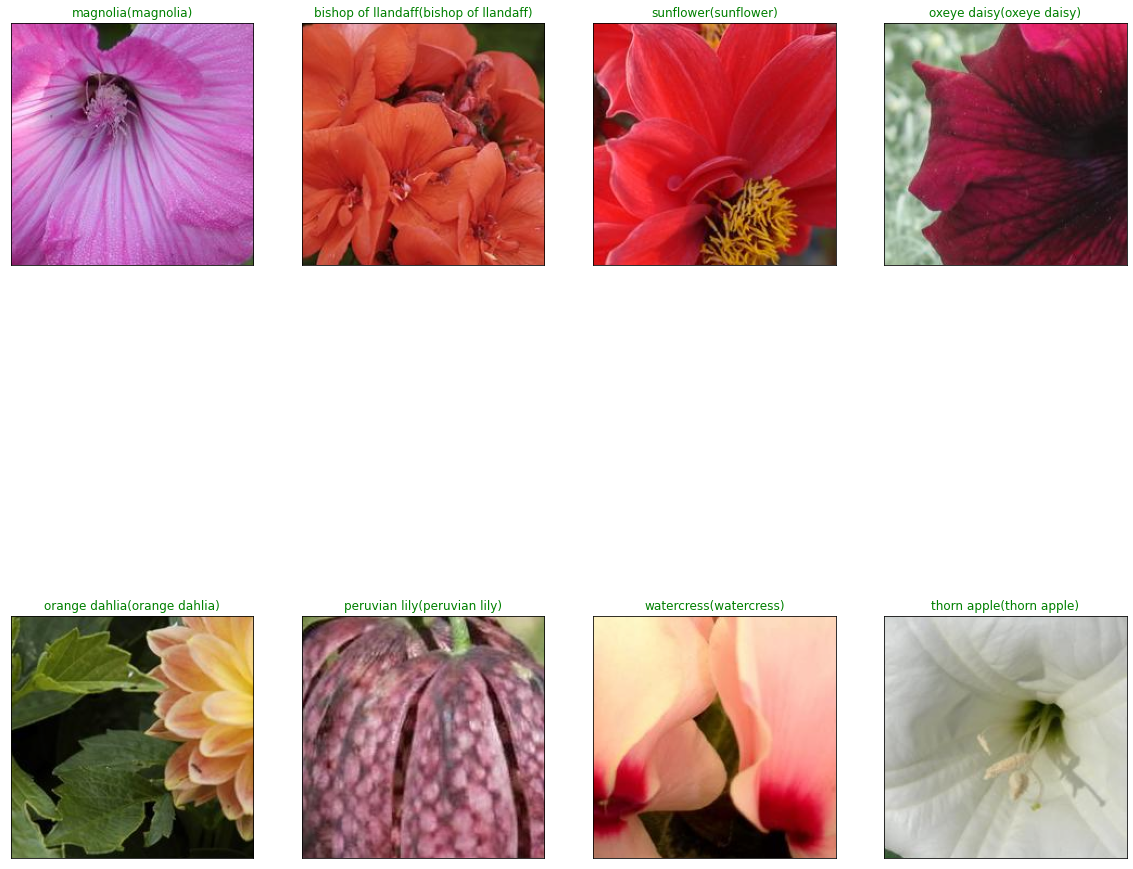

In [78]:
fig = plt.figure(figsize=(20,20))
cols = 4
rows = 2

for idx in range(cols * rows):
    ax = fig.add_subplot(rows, cols, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{}({})".format(cat_to_name[str(preds[idx])], cat_to_name[str(labels[idx].item())]),
                color=('green' if preds[idx] == int(labels[idx].item()) else 'red') )
plt.show()

In [73]:
labels[idx].item()

92

In [82]:
def process_image(image_path):
    # 读取测试数据
    img = Image.open(image_path)
    # Resize,thumbnail方法只能进行缩小，所以进行了判断
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop操作
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # 相同的预处理方法
    img = np.array(img)/255
    mean = np.array(means) #provided mean
    std = np.array(varis) #provided std
    img = (img - mean)/std
    
    # 注意颜色通道应该放在第一个位置
    img = img.transpose((2, 0, 1))
    
    return img

def imshow(image, ax=None, title=None):
    """展示数据"""
    if ax is None:
        fig, ax = plt.subplots()
    
    # 颜色通道还原
    image = np.array(image).transpose((1, 2, 0))
    
    # 预处理还原
    mean = np.array(means)
    std = np.array(varis)
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    ax.set_title(title)
    
    return ax

<AxesSubplot:>

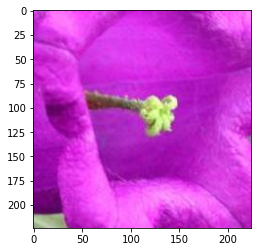

In [92]:
image_path = './flower_data/image_06621.jpg'
# img = process_image(image_path)
image = Image.open(image_path)
img = data_transforms['valid'](image)
imshow(img)

In [104]:
result = model_ft(torch.unsqueeze(img, 0).cuda())
_, result = torch.max(result, 1)
ret = result.cpu().numpy()
ret[0]
cat_to_name[str(ret[0])]

'grape hyacinth'